In [1]:
from used_packages import *
from models_downstream import *
from utils import *
sys.setrecursionlimit(10000)

C:\Users\Ali\miniconda3\envs\TF3_7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using TensorFlow backend.


In [2]:

data_train = pd.read_csv('train.csv', header=0)[::-1]
states = pd.read_csv('store_states.csv', header=0)
data_train = pd.merge(data_train, states, on='Store')
data_train = data_train[data_train['Sales'] != 0]
#data_train['DofWeek'] = data_train['DayOfWeek']
#data_train['Holiday'] = data_train['StateHoliday']
X_tr = data_train.drop(columns=['Sales', 'Customers'])
y_tr = data_train['Sales']
print(X_tr.columns)
X_tr['Date'] = pd.to_datetime(X_tr['Date'])
X_tr['Year'] = X_tr['Date'].dt.year
X_tr['Month'] = X_tr['Date'].dt.month
X_tr['Day'] = X_tr['Date'].dt.day

X_tr = X_tr.drop(columns=['Date'])  #,'StateHoliday'
X_tr = X_tr[['Store', 'DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'State']]

X_tr = X_tr.astype(str)
print(X_tr.columns)


ohe = OneHotEncoder(sparse=False)
X_encoded = ohe.fit_transform(X_tr)

# Convert back to DataFrame with meaningful column names
X_encoded = pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(X_tr.columns), index=X_tr.index)

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'State'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'State'], dtype='object')


# Use EE dataset to extract lasso coefs

In [3]:
sys.setrecursionlimit(10000)

train_ratio = 0.9
shuffle_data = False
one_hot_as_input = True
embeddings_as_input = False
save_embeddings = False
saved_embeddings_fname = "embeddings.pickle"  # set save_embeddings to True to create this file

In [4]:
f = open('feature_train_data.pickle', 'rb')
(X, y) = pickle.load(f)
X = X[:, 1:]
X_or = X.copy()
original_cols = [f'x{i}' for i in range(X.shape[1])]
X_or = pd.DataFrame(X_or, columns=original_cols)
num_records = len(X)
train_size = int(train_ratio * num_records)

if shuffle_data:
    print("Using shuffled data")
    sh = np.arange(X.shape[0])
    np.random.shuffle(sh)
    X = X[sh]
    y = y[sh]

if embeddings_as_input:
    print("Using learned embeddings as input")
    X = embed_features(X, saved_embeddings_fname)

if X.shape[1] == 1183:
    X = X[:, 1:]
elif X.shape[1] == 8:
    X = X[:, 1:]

if one_hot_as_input:
    print("Using one-hot encoding as input")
    enc = OneHotEncoder(sparse=False)
    enc.fit(X)
    X = enc.transform(X)


X_EE_Full_col_names = pd.DataFrame(X, columns=enc.get_feature_names_out())

Using one-hot encoding as input


# Group Lasso using bayesian optimization

We want to use group lasso on 4 splits over the large dataset, each with roughly 211k datapoints, then average the coefs.

We'll use bayesian optimization to find the optimal regularization parameters $\lambda_1$ and $\lambda_2$ based on the Sparse Group Lasso Formula:

$$\arg\min_\beta \left( L(\beta, \mathbf{X}, \mathbf{y}) + \lambda_1 \|\beta\|_1 + \lambda_2 \sum \|\beta_{\text{group}}\|_2 \right)$$

In [5]:
from utils import glasso

def objective(trial):

    # stratified K-Fold CV
    skf = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
    mape_subs = []
    splits = skf.split(X_EE_Full_col_names, y)
    for i, (_, test_index) in enumerate(splits):

        X_sub = X_EE_Full_col_names.iloc[test_index]
        y_sub = y[test_index]

        X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.1, random_state=0, shuffle=False)

        print(f'Fitting Fold {i+1}/{skf.get_n_splits()} - Train size: {len(X_train)} - Test size: {len(X_test)}')
        l1_reg = trial.suggest_float('l1_reg', 1e-6, 1e2, log=True)
        alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)
        title = f'- Group-LASSO - l1 = {l1_reg}'
        model_gl2, coefs_gl2, lam_gl2, ypred_gl, group_lass_labels, labels, mape = (
            glasso(X_train, y_train, X_test, y_test, X_or, alpha=alpha,
                         scoring='MAPE',
                         no_groups=False,
                         l1_reg=l1_reg,
                         n_iter=50,
                         tol=1e-3,
                         cmap='tab10',
                         title=title,
                         save_plot=False,
                         verbose=False))
        mape_subs.append(mape)
        print(f'\tMAPE: {mape}')
    mape_subs = np.array(mape_subs).mean(axis=0)
    return mape_subs

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
l1_reg_best = best_params['l1_reg']
lambda_best = best_params['alpha']

title = f'- Group-LASSO - Optuna Best - l1 = {l1_reg_best}'
original_labels = X_EE_Full_col_names.columns.tolist()

# stratified K-Fold CV
skf = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
skf.split(X_EE_Full_col_names, y)
coefs_subs_best = []
for i, (_, test_index) in enumerate(skf.split(X_EE_Full_col_names, y)):

    X_sub = X_EE_Full_col_names.iloc[test_index]
    y_sub = y[test_index]

    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.1, random_state=0, shuffle=False)

    model_best, coefs_best, lam_best, ypred_best, groups_best, labels_best, mape_best = (
        glasso(X_train, y_train, X_test, y_test, X_or, alpha=lambda_best,
                     scoring='MAPE',
                     no_groups=False,
                     l1_reg=l1_reg_best,
                     n_iter=50,
                     tol=1e-3,
                     cmap='tab10',
                     title=title,
                     save_plot=True,
                     verbose=True))
    coefs_subs_best.append(coefs_best)

[I 2025-04-04 10:42:57,801] A new study created in memory with name: no-name-c46798bc-2c9e-4707-8b50-293aae87db36


Fitting Fold 1/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.16919472526240464
Fitting Fold 2/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.19079908514065225
Fitting Fold 3/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.18180343939875354
Fitting Fold 4/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.1424591436779349


[I 2025-04-04 10:45:36,760] Trial 0 finished with value: 0.17106409836993633 and parameters: {'l1_reg': 0.00019353811505111825, 'alpha': 1.603831675050436}. Best is trial 0 with value: 0.17106409836993633.


Fitting Fold 1/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.1691853939119981
Fitting Fold 2/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.19078568976883623
Fitting Fold 3/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.18180343939875354
Fitting Fold 4/4 - Train size: 189975 - Test size: 21109


[I 2025-04-04 10:47:59,660] Trial 1 finished with value: 0.17105956212968326 and parameters: {'l1_reg': 4.80524269118806e-05, 'alpha': 0.46489775038424946}. Best is trial 1 with value: 0.17105956212968326.


	MAPE: 0.14246372543914518
Fitting Fold 1/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.25421369331004245
Fitting Fold 2/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.23187336263091285
Fitting Fold 3/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.24314107336885418
Fitting Fold 4/4 - Train size: 189975 - Test size: 21109


[I 2025-04-04 10:50:02,283] Trial 2 finished with value: 0.23654147312429374 and parameters: {'l1_reg': 41.62408003403564, 'alpha': 0.05507388953587317}. Best is trial 1 with value: 0.17105956212968326.


	MAPE: 0.21693776318736546
Fitting Fold 1/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.16919285728483635
Fitting Fold 2/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.19079393603356445
Fitting Fold 3/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.18180343939875354
Fitting Fold 4/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.1424598354790511


[I 2025-04-04 10:52:18,606] Trial 3 finished with value: 0.17106251704905134 and parameters: {'l1_reg': 7.918297035116001e-05, 'alpha': 0.9075120933739441}. Best is trial 1 with value: 0.17105956212968326.


Fitting Fold 1/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.3342897312174515
Fitting Fold 2/4 - Train size: 189976 - Test size: 21109
	MAPE: 0.3861852182256205
Fitting Fold 3/4 - Train size: 189975 - Test size: 21109
	MAPE: 0.22741910618327946
Fitting Fold 4/4 - Train size: 189975 - Test size: 21109


[I 2025-04-04 10:54:26,061] Trial 4 finished with value: 0.27391507048326813 and parameters: {'l1_reg': 0.020055791652535987, 'alpha': 31.86748452913087}. Best is trial 1 with value: 0.17105956212968326.


	MAPE: 0.14776622630672112
Best trial:
  Value: 0.17105956212968326
  Params: 
    l1_reg: 4.80524269118806e-05
    alpha: 0.46489775038424946
Original Labels
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

Group Numbers
[1 1 1 ... 7 7 7]

1/10 lambda: 4.65e-01 - Selected features: 1108 - MAPE = 0.1691853939
Original Labels
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

Group Numbers
[1 1 1 ... 7 7 7]

1/10 lambda: 4.65e-01 - Selected features: 1097 - MAPE = 0.1907856898
Original Labels
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

Group Numbers
[1 1 1 ... 7 7 7]

1/10 lambda: 4.65e-01 - Selected features: 1104 - MAPE = 0.1818034394
Original Labels
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

Group Numbers
[1 1 1 ... 7 7 7]

1/10 lambda: 4.65e-01 - Selected features: 1102 - MAPE = 0.1424637254


# Mean Shift

Cluster the Lasso coefficients for each group

In [6]:
labels_dict = dict(zip(labels_best, ['Store', 'DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'State']))

coefs_mean = np.array(coefs_subs_best).mean(axis=0)


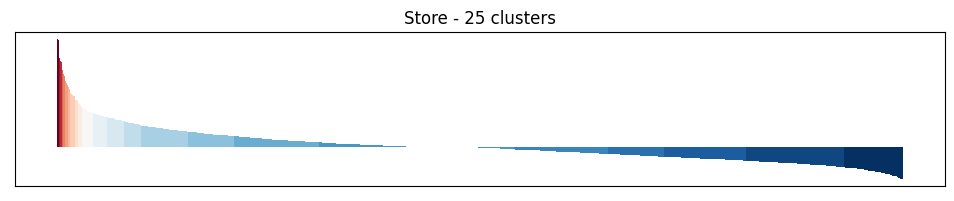

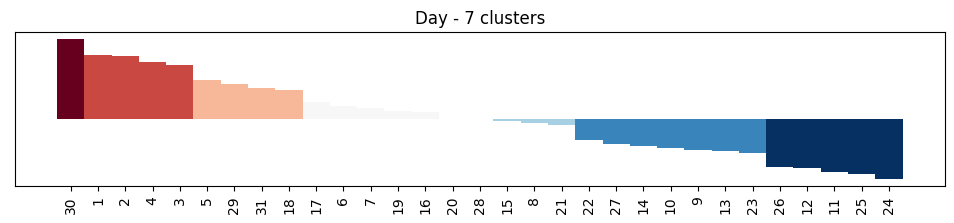

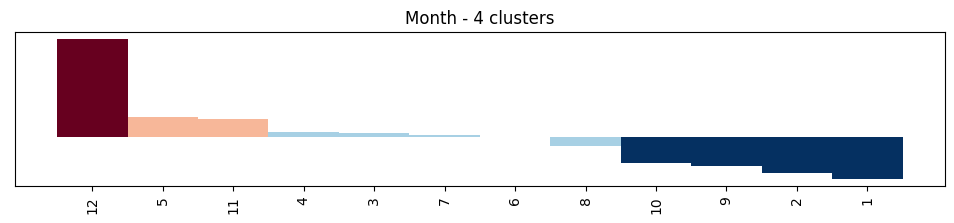

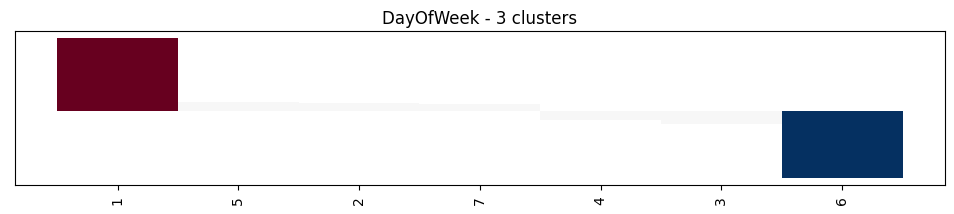

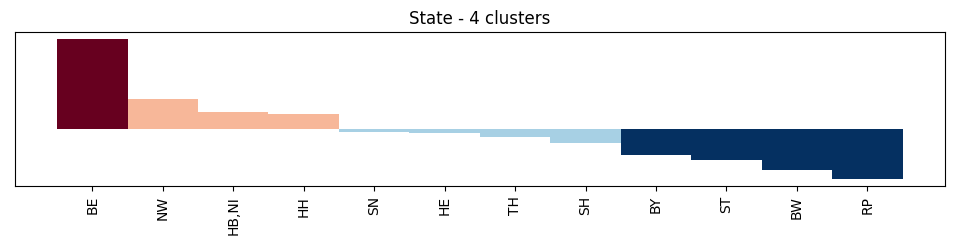

In [7]:
from utils import cluster_mean_shift

save = False

main_labels_dict = dict(zip(labels_best, range(1, len(labels_best)+1)))
store_dict = cluster_mean_shift(X_EE_Full_col_names, X_encoded, main_labels_dict['x0'], groups_best, labels_best, coefs_mean, labels_dict, band = 0.01, threshold=0.001, min_clusters=25, max_clusters=25, merge_middle_clusters=False, merge_threshold=0.02, xticks=False, save_plot=save, barwidth=1)


day_dict = cluster_mean_shift(X_EE_Full_col_names, X_encoded, main_labels_dict['x5'], groups_best, labels_best, coefs_mean, labels_dict, band = 0.1, threshold=0.001, min_clusters=7, max_clusters=8, xticks=True, save_plot=save, barwidth=1)


month_dict = cluster_mean_shift(X_EE_Full_col_names, X_encoded, main_labels_dict['x4'], groups_best, labels_best, coefs_mean, labels_dict, band = 0.1, threshold=0.001, min_clusters=3, max_clusters=5, merge_middle_clusters=False, xticks=True, save_plot=save, barwidth=1)


dayOfWeek_dict = cluster_mean_shift(X_EE_Full_col_names, X_encoded, main_labels_dict['x1'], groups_best, labels_best, coefs_mean, labels_dict, band = 0.1, threshold=0.001, min_clusters=3, max_clusters=3, merge_middle_clusters=False, xticks=True, save_plot=save, barwidth=1)


state_dict = cluster_mean_shift(X_EE_Full_col_names, X_encoded, main_labels_dict['x6'], groups_best, labels_best, coefs_mean, labels_dict, band = 0.1, threshold=0.001, min_clusters=3, max_clusters=4, merge_middle_clusters=False, xticks=True, save_plot=save, barwidth=1)

final_dicts = [store_dict, day_dict, month_dict, dayOfWeek_dict, state_dict]

X_final = X_or.copy()
for i, d in enumerate(['x0', 'x5', 'x4', 'x1', 'x6']):
    X_final[f'{d}'] = X_final[f'{d}'].apply(lambda x: final_dicts[i][str(x)])

In [8]:
X_tr['State'].sort_values().unique()

array(['BE', 'BW', 'BY', 'HB,NI', 'HE', 'HH', 'NW', 'RP', 'SH', 'SN',
       'ST', 'TH'], dtype=object)

# plot state clusters

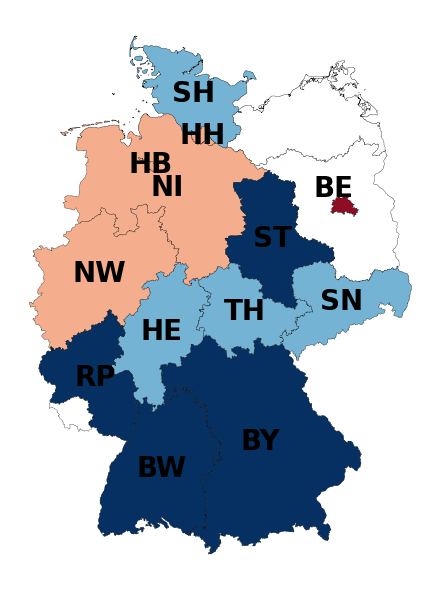

In [9]:
import geopandas as gpd
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Download Germany administrative boundaries
url = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json"
germany = gpd.read_file(url)

# Based on the corrected cluster information:
# Cluster 1: BE
# Cluster 2: NW, HB, NI, HH
# Cluster 3: SN, HE, TH, SH
# Cluster 4: BY, ST, BW, RP
# Unassigned (0): BB, MV, SL
cluster_mapping = {
    'BE': 1,  # Berlin

    'NW': 2,  # North Rhine-Westphalia
    'HB': 2,  # Bremen
    'NI': 2,  # Lower Saxony
    'HH': 2,  # Hamburg

    'SN': 3,  # Saxony
    'HE': 3,  # Hesse
    'TH': 3,  # Thuringia
    'SH': 3,  # Schleswig-Holstein

    'BY': 4,  # Bavaria
    'ST': 4,  # Saxony-Anhalt
    'BW': 4,  # Baden-Württemberg
    'RP': 4,  # Rhineland-Palatinate

    # exclude states
    'MV': 0,  # Mecklenburg-Vorpommern
    'SL': 0,  # Saarland
    'BB': 0,  # Brandenburg
}

# map the state names to the abbreviations
state_name_to_abbr = {
    'Baden-Württemberg': 'BW',
    'Bayern': 'BY',
    'Berlin': 'BE',
    'Brandenburg': 'BB',
    'Bremen': 'HB',
    'Hamburg': 'HH',
    'Hessen': 'HE',
    'Mecklenburg-Vorpommern': 'MV',
    'Niedersachsen': 'NI',
    'Nordrhein-Westfalen': 'NW',
    'Rheinland-Pfalz': 'RP',
    'Saarland': 'SL',
    'Sachsen': 'SN',
    'Sachsen-Anhalt': 'ST',
    'Schleswig-Holstein': 'SH',
    'Thüringen': 'TH'
}

# Add cluster information to the GeoDataFrame
germany['cluster'] = germany['name'].map(lambda x: cluster_mapping.get(state_name_to_abbr.get(x, 'Unknown'), 0))

cmap = cm.get_cmap('RdBu', 20)

c1 = cmap(1)
c2 = cmap(6)
c3 = cmap(14)
c4 = cmap(19)


# custom colormap with 5 colors
colors = ['white', c1, c2, c3, c4]
cmap = mcolors.ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
germany.plot(column='cluster', ax=ax, cmap=cmap, norm=norm, edgecolor='black', linewidth=0.2)

# custom legend
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='No stores'),
    Patch(facecolor=c1, edgecolor='black', label='Cluster 1'),
    Patch(facecolor=c2, edgecolor='black', label='Cluster 2'),
    Patch(facecolor=c3, edgecolor='black', label='Cluster 3'),
    Patch(facecolor=c4, edgecolor='black', label='Cluster 4')
]
#ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# label positions to avoid overlap
label_adjustments = {
    'Berlin': {'x_offset': -0.25, 'y_offset': 0.25},         # Keep Berlin centered
    'Brandenburg': {'x_offset': 0.4, 'y_offset': -0.6}  # Move Brandenburg label further down
}

# state labels with custom positions for certain states
for idx, row in germany.iterrows():
    if row['cluster'] != 0:
        state_name = row['name']
        abbr = state_name_to_abbr.get(state_name, '')

        # centroid coordinates
        x = row.geometry.centroid.x
        Y = row.geometry.centroid.y

        # adjustments if needed
        if state_name in label_adjustments:
            x_offset = label_adjustments[state_name]['x_offset']
            Y_offset = label_adjustments[state_name]['y_offset']
            x += x_offset
            Y += Y_offset

        ax.annotate(abbr, xy=(x, Y), ha='center', va='center', fontsize=20, fontweight='bold', color='black')

plt.axis('off')
plt.tight_layout()
#plt.savefig('germany_clusters_map.pdf', bbox_inches='tight')
plt.show()

In [10]:
d = data_train.groupby('State').agg(
    **{
        'No. of Stores': ('Store', 'nunique'),
        'Total Sales': ('Sales', 'sum')
    }
).reset_index().sort_values(by='Total Sales', ascending=False)
d

,State,No. of Stores,Total Sales
6,NW,286,1598936483
2,BY,180,742361827
8,SH,115,618426981
0,BE,92,604709903
4,HE,112,603605998
9,SN,75,402442109
1,BW,73,355745661
10,ST,56,276915114
11,TH,36,188595349
7,RP,40,181243703


In [11]:
X_store = X_tr.copy()
for i, d in enumerate(['Store']):
    X_store[f'{d}'] = X_store[f'{d}'].apply(lambda x: store_dict[str(int(x)-1)])

In [14]:
majority_state = X_store.groupby('Store')['State'].agg(lambda x: x.value_counts().idxmax())
store_counts_per_state = majority_state.value_counts().rename("No. of Store Clusters with This Majority State").rename_axis("State")
store_counts_per_state


State
NW    15
SH     6
BE     2
HE     1
HH     1
Name: No. of Store Clusters with This Majority State, dtype: int64

# Train Using Lasso Reduced Dimensions

In [15]:
ohe = OneHotEncoder(sparse=False)  # Use sparse=False instead of sparse_output=False
X_final_ohe = ohe.fit_transform(X_final)

# Convert back to DataFrame with meaningful column names
X_final_ohe = pd.DataFrame(X_final_ohe, columns=ohe.get_feature_names_out(X_final.columns), index=X_final.index)

X = X_final_ohe.copy()

train_ratio = 0.9

num_records = len(X)
train_size = int(train_ratio * num_records)

X_train = np.array(X[:train_size])
X_val = np.array(X[train_size:])
y_train = np.array(y[:train_size])
y_val = np.array(y[train_size:])

print("Using LASSO clusters as input")
X_train, y_train, idx, seed_lasso = sample(X_train, y_train, 200000, seed=10)  # Simulate data sparsity
print("Number of samples used for training: " + str(y_train.shape[0]))

percent_reduct_lasso = 1 - X_final_ohe.shape[1] / X_EE_Full_col_names.shape[1]
print(f'Original features: {X_EE_Full_col_names.shape[1]}, Reduced features: {X_train.shape[1]}')
print(f'Percent Reduction: {percent_reduct_lasso:0.3%}%')

Using LASSO clusters as input
Number of samples used for training: 200000
Original features: 1182, Reduced features: 48
Percent Reduction: 95.939%%


### Neural Network - Lasso Clusters

In [17]:
lasso_mape = defaultdict()

models = []

print("Fitting NN...")
for i in range(5):
    models.append(NN(X_train, y_train, X_val, y_val))

print("Evaluate combined models...")
print("Training error...")
r_train_lass_NN = evaluate_models(models, X_train, y_train)
print(r_train_lass_NN)

print("Validation error...")
r_val_lass_NN = evaluate_models(models, X_val, y_val)
print(r_val_lass_NN)
lasso_mape['NN_lasso'] = r_val_lass_NN


Fitting NN...
Train on 200000 samples, validate on 84434 samples
Epoch 1/10
200000/200000 [==============================] - 9s 47us/step - loss: 0.0147 - val_loss: 0.0137
Epoch 2/10
200000/200000 [==============================] - 9s 47us/step - loss: 0.0134 - val_loss: 0.0144
Epoch 3/10
200000/200000 [==============================] - 9s 44us/step - loss: 0.0132 - val_loss: 0.0143
Epoch 4/10
200000/200000 [==============================] - 9s 46us/step - loss: 0.0131 - val_loss: 0.0151
Epoch 5/10
200000/200000 [==============================] - 9s 44us/step - loss: 0.0130 - val_loss: 0.0138
Epoch 6/10
200000/200000 [==============================] - 9s 45us/step - loss: 0.0130 - val_loss: 0.0140
Epoch 7/10
200000/200000 [==============================] - 9s 45us/step - loss: 0.0129 - val_loss: 0.0145
Epoch 8/10
200000/200000 [==============================] - 9s 45us/step - loss: 0.0129 - val_loss: 0.0145
Epoch 9/10
200000/200000 [==============================] - 9s 46us/step - loss

### Random Forest - Lasso Clusters

In [18]:
models = []

print("Fitting RF...")
models.append(RF(X_train, y_train, X_val, y_val))

print("Evaluate combined models...")
print("Training error...")
r_train_lass_rf = evaluate_models(models, X_train, y_train)
print(r_train_lass_rf)

print("Validation error...")
r_val_lass_rf = evaluate_models(models, X_val, y_val)
print(r_val_lass_rf)

lasso_mape['rf_lasso'] = r_val_lass_rf

Fitting RF...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished


Result on validation data:  0.15742579711274782
Evaluate combined models...
Training error...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


0.13339898041422285
Validation error...
0.1574257971127478


[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished


### XGBoost - Lasso Clusters

In [ ]:
models = []

print("Fitting XGBoost...")
models.append(XGBoost(X_train, y_train, X_val, y_val))

print("Evaluate combined models...")
print("Training error...")
r_train_lass_xg = evaluate_models(models, X_train, y_train)
print(r_train_lass_xg)

print("Validation error...")
r_val_lass_xg = evaluate_models(models, X_val, y_val)
print(r_val_lass_xg)

lasso_mape['xg_lasso'] = r_val_lass_xg

### KNN - Lasso Clusters

In [20]:
models = []

print("Fitting KNN...")
models.append(KNN(X_train, y_train, X_val, y_val))

print("Validation error...")
r_val_lass_knn = evaluate_models(models, X_val, y_val)
print(r_val_lass_knn)

lasso_mape['knn_lasso'] = r_val_lass_knn


Fitting KNN...
Initializing normalizer...
Initializing KNN model with n_neighbors=10, p=1, weights='distance'...
Fitting KNN model on training data...
Evaluating model on validation data...
Making a prediction...
Result on validation data: 0.16828723747426982
Validation error...
Making a prediction...
0.16719155455600426


# Train Using Entity Embeddings

In [21]:
#from models import *
sys.setrecursionlimit(10000)

train_ratio = 0.9
shuffle_data = False
one_hot_as_input = False
embeddings_as_input = True
save_embeddings = False
saved_embeddings_fname = "embeddings.pickle"  # set save_embeddings to True to create this file

f = open('feature_train_data.pickle', 'rb')
(X, y) = pickle.load(f)

num_records = len(X)
train_size = int(train_ratio * num_records)

if shuffle_data:
    print("Using shuffled data")
    sh = np.arange(X.shape[0])
    np.random.shuffle(sh)
    X = X[sh]
    y = y[sh]

if embeddings_as_input:
    print("Using learned embeddings as input")
    X = embed_features(X, saved_embeddings_fname)

if one_hot_as_input:
    print("Using one-hot encoding as input")
    enc = OneHotEncoder(sparse=False)
    enc.fit(X)
    X = enc.transform(X)

if X.shape[1] == 1183:
    X = X[:, 1:]
elif X.shape[1] == 8:
    X = X[:, 1:]

X_train_ee = X[:train_size]
X_val_ee = X[train_size:]
y_train_ee = y[:train_size]
y_val_ee = y[train_size:]


X_train_ee, y_train_ee, idx_ee, seed_ee = sample(X_train_ee, y_train_ee, 200000, seed=10)
#assert(seed_ee == seed_lasso)
print("Number of samples used for training: " + str(y_train_ee.shape[0]))

percent_reduct_ee = 1 - X_train_ee.shape[1] / X_EE_Full_col_names.shape[1]
print(f'Original features: {X_EE_Full_col_names.shape[1]}, Reduced features: {X_train_ee.shape[1]}')
print(f'Percent Reduction: {percent_reduct_ee:0.3%}%')

Using learned embeddings as input
Number of samples used for training: 200000
Original features: 1182, Reduced features: 42
Percent Reduction: 96.447%%


### Neural Network - EE

In [22]:
#assert(seed_ee == seed_lasso)
ee_mape = defaultdict()
models = []

print("Fitting NN...")
for i in range(5):
    models.append(NN(X_train_ee, y_train_ee, X_val_ee, y_val_ee))

print("evaluate combined models...")
print("Training error...")
r_train_ee_NN = evaluate_models(models, X_train_ee, y_train_ee)
print(r_train_ee_NN)

print("validation error...")
r_val_ee_NN = evaluate_models(models, X_val_ee, y_val_ee)
print(r_val_ee_NN)
ee_mape['NN_ee'] = r_val_ee_NN


Fitting NN...
Train on 200000 samples, validate on 84434 samples
Epoch 1/10
200000/200000 [==============================] - 10s 49us/step - loss: 0.0103 - val_loss: 0.0095
Epoch 2/10
200000/200000 [==============================] - 10s 48us/step - loss: 0.0078 - val_loss: 0.0097
Epoch 3/10
200000/200000 [==============================] - 10s 48us/step - loss: 0.0075 - val_loss: 0.0095
Epoch 4/10
200000/200000 [==============================] - 10s 49us/step - loss: 0.0072 - val_loss: 0.0095
Epoch 5/10
200000/200000 [==============================] - 10s 50us/step - loss: 0.0072 - val_loss: 0.0095
Epoch 6/10
200000/200000 [==============================] - 10s 49us/step - loss: 0.0070 - val_loss: 0.0095
Epoch 7/10
200000/200000 [==============================] - 10s 49us/step - loss: 0.0069 - val_loss: 0.0091
Epoch 8/10
200000/200000 [==============================] - 10s 49us/step - loss: 0.0069 - val_loss: 0.0100
Epoch 9/10
200000/200000 [==============================] - 10s 48us/st

### Random Forest - EE

In [23]:
models = []

print("Fitting RF...")
models.append(RF(X_train_ee, y_train_ee, X_val_ee, y_val_ee))

print("evaluate combined models...")
print("Training error...")
r_train_ee_rf = evaluate_models(models, X_train_ee, y_train_ee)
print(r_train_ee_rf)

print("validation error...")
r_val_ee_rf = evaluate_models(models, X_val_ee, y_val_ee)
print(r_val_ee_rf)

ee_mape['rf_ee'] = r_val_ee_rf

Fitting RF...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


Result on validation data:  0.10521072346095404
evaluate combined models...
Training error...


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


0.02743802686811462
validation error...
0.10521072346095404


[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.3s finished


### XGBoost - EE

In [ ]:
models = []

print("Fitting XGBoost...")
models.append(XGBoost(X_train_ee, y_train_ee, X_val_ee, y_val_ee))

print("evaluate combined models...")
print("Training error...")
r_train_ee_xg = evaluate_models(models, X_train_ee, y_train_ee)
print(r_train_ee_xg)

print("validation error...")
r_val_ee_xg = evaluate_models(models, X_val_ee, y_val_ee)
print(r_val_ee_xg)

ee_mape['xg_ee'] = r_val_ee_xg

### KNN - EE

In [25]:
models = []

print("Fitting KNN...")
models.append(KNN(X_train_ee, y_train_ee, X_val_ee, y_val_ee))

print("evaluate combined models...")
print("Training error...")
r_train_ee_knn = evaluate_models(models, X_train_ee, y_train_ee)
print(r_train_ee_knn)

print("validation error...")
r_val_ee_knn = evaluate_models(models, X_val_ee, y_val_ee)
print(r_val_ee_knn)

ee_mape['knn_ee'] = r_val_ee_knn

Fitting KNN...
Initializing normalizer...
Initializing KNN model with n_neighbors=10, p=1, weights='distance'...
Fitting KNN model on training data...
Evaluating model on validation data...
Making a prediction...
Result on validation data: 0.11386260928379972
evaluate combined models...
Training error...
Making a prediction...
4.336211704276612e-16
validation error...
Making a prediction...
0.11386260928379972


# Train Using Full set

In [26]:
train_ratio = 0.9
shuffle_data = False
one_hot_as_input = True
embeddings_as_input = False
save_embeddings = False
saved_embeddings_fname = "embeddings.pickle"  # set save_embeddings to True to create this file

f = open('feature_train_data.pickle', 'rb')
(X, y) = pickle.load(f)

num_records = len(X)
train_size = int(train_ratio * num_records)

if shuffle_data:
    print("Using shuffled data")
    sh = np.arange(X.shape[0])
    np.random.shuffle(sh)
    X = X[sh]
    y = y[sh]

if embeddings_as_input:
    print("Using learned embeddings as input")
    X = embed_features(X, saved_embeddings_fname)

if one_hot_as_input:
    print("Using one-hot encoding as input")
    enc = OneHotEncoder(sparse=False)
    enc.fit(X)
    X = enc.transform(X)

if X.shape[1] == 1183:
    X = X[:, 1:]
elif X.shape[1] == 8:
    X = X[:, 1:]

X_train_full = X[:train_size]
X_val_full = X[train_size:]
y_train_full = y[:train_size]
y_val_full = y[train_size:]

X_train_full, y_train_full, idx_full, seed_full = sample(X_train_full, y_train_full, 200000, seed=10)
#assert(seed_full == seed_lasso == seed_ee)
print("Number of samples used for training: " + str(y_train_full.shape[0]))

percent_reduct_full = 1 - X_train_full.shape[1] / X_EE_Full_col_names.shape[1]
print(f'Original features: {X_EE_Full_col_names.shape[1]}')
print(f'Percent Reduction: {percent_reduct_full:0.3%}%')

Using one-hot encoding as input
Number of samples used for training: 200000
Original features: 1182
Percent Reduction: 0.000%%


### Extract Entity Embeddings

In [27]:
'''#assert(seed_full == seed_lasso == seed_ee)
models = []

print("Fitting NN_with_EntityEmbedding...")
for i in range(5):
    models.append(NN_with_EntityEmbedding(X_train_full, y_train_full, X_val_full, y_val_full))

if save_embeddings:
    model = models[0].model
    store_embedding = model.get_layer('store_embedding').get_weights()[0]
    dow_embedding = model.get_layer('dow_embedding').get_weights()[0]
    year_embedding = model.get_layer('year_embedding').get_weights()[0]
    month_embedding = model.get_layer('month_embedding').get_weights()[0]
    day_embedding = model.get_layer('day_embedding').get_weights()[0]
    german_states_embedding = model.get_layer('state_embedding').get_weights()[0]
    with open(saved_embeddings_fname, 'wb') as f:
        pickle.dump([store_embedding, dow_embedding, year_embedding,
                     month_embedding, day_embedding, german_states_embedding], f, -1)

print("Evaluate combined models...")
print("Training error...")
r_train_full_NN = evaluate_models(models, X_train_full, y_train_full)
print(r_train_full_NN)

print("validation error...")
r_val_full_NN = evaluate_models(models, X_val_full, y_val_full)
print(r_val_full_NN)
full_mape['NN_full'] = r_val_full_NN'''

'#assert(seed_full == seed_lasso == seed_ee)\nmodels = []\n\nprint("Fitting NN_with_EntityEmbedding...")\nfor i in range(5):\n    models.append(NN_with_EntityEmbedding(X_train_full, y_train_full, X_val_full, y_val_full))\n\nif save_embeddings:\n    model = models[0].model\n    store_embedding = model.get_layer(\'store_embedding\').get_weights()[0]\n    dow_embedding = model.get_layer(\'dow_embedding\').get_weights()[0]\n    year_embedding = model.get_layer(\'year_embedding\').get_weights()[0]\n    month_embedding = model.get_layer(\'month_embedding\').get_weights()[0]\n    day_embedding = model.get_layer(\'day_embedding\').get_weights()[0]\n    german_states_embedding = model.get_layer(\'state_embedding\').get_weights()[0]\n    with open(saved_embeddings_fname, \'wb\') as f:\n        pickle.dump([store_embedding, dow_embedding, year_embedding,\n                     month_embedding, day_embedding, german_states_embedding], f, -1)\n\nprint("Evaluate combined models...")\nprint("Training 

### Neural Network - Full set

In [28]:
full_mape = defaultdict()
#assert(seed_full == seed_lasso == seed_ee)
models = []

print("Fitting NN...")
for i in range(5):
    models.append(NN(X_train_full, y_train_full, X_val_full, y_val_full))

print("Evaluate combined models...")
print("Training error...")
r_train_full_NN = evaluate_models(models, X_train_full, y_train_full)
print(r_train_full_NN)

print("validation error...")
r_val_full_NN = evaluate_models(models, X_val_full, y_val_full)
print(r_val_full_NN)
full_mape['NN_full'] = r_val_full_NN

Fitting NN...
Train on 200000 samples, validate on 84434 samples
Epoch 1/10
200000/200000 [==============================] - 26s 132us/step - loss: 0.0124 - val_loss: 0.0122
Epoch 2/10
200000/200000 [==============================] - 26s 131us/step - loss: 0.0082 - val_loss: 0.0119
Epoch 3/10
200000/200000 [==============================] - 26s 132us/step - loss: 0.0072 - val_loss: 0.0102
Epoch 4/10
200000/200000 [==============================] - 26s 131us/step - loss: 0.0065 - val_loss: 0.0103
Epoch 5/10
200000/200000 [==============================] - 26s 132us/step - loss: 0.0059 - val_loss: 0.0100
Epoch 6/10
200000/200000 [==============================] - 26s 132us/step - loss: 0.0055 - val_loss: 0.0098
Epoch 7/10
200000/200000 [==============================] - 26s 131us/step - loss: 0.0051 - val_loss: 0.0099
Epoch 8/10
200000/200000 [==============================] - 26s 132us/step - loss: 0.0047 - val_loss: 0.0099
Epoch 9/10
200000/200000 [==============================] - 26s

### Random Forest - Full set

In [29]:
models = []

print("Fitting RF...")
models.append(RF(X_train_full, y_train_full, X_val_full, y_val_full))

print("Evaluate combined models...")
print("Training error...")
r_train_full_rf = evaluate_models(models, X_train_full, y_train_full)
print(r_train_full_rf)

print("validation error...")
r_val_full_rf = evaluate_models(models, X_val_full, y_val_full)
print(r_val_full_rf)

full_mape['rf_full'] = r_val_full_rf

Fitting RF...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 37.0min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.6s finished


Result on validation data:  0.22844923682115076
Evaluate combined models...
Training error...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.3s finished


0.22753428155848654
validation error...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


0.22844923682115081


[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.7s finished


### XGBoost - Full set

In [ ]:
models = []

print("Fitting XGBoost...")
models.append(XGBoost(X_train_full, y_train_full, X_val_full, y_val_full))

print("Evaluate combined models...")
print("Training error...")
r_train_full_xg = evaluate_models(models, X_train_full, y_train_full)
print(r_train_full_xg)

print("validation error...")
r_val_full_xg = evaluate_models(models, X_val_full, y_val_full)
print(r_val_full_xg)

full_mape['xg_full'] = r_val_full_xg

### KNN - Full set

In [31]:
models = []

print("Fitting KNN...")
models.append(KNN(X_train_full, y_train_full, X_val_full, y_val_full))

print("Evaluate combined models...")
print("Training error...")
r_train_full_knn = evaluate_models(models, X_train_full, y_train_full)
print(r_train_full_knn)

print("validation error...")
r_val_full_knn = evaluate_models(models, X_val_full, y_val_full)
print(r_val_full_knn)

full_mape['knn_full'] = r_val_full_knn

Fitting KNN...
Initializing normalizer...
Initializing KNN model with n_neighbors=10, p=1, weights='distance'...
Fitting KNN model on training data...
Evaluating model on validation data...
Making a prediction...
Result on validation data: 0.20957339940794487
Evaluate combined models...
Training error...
Making a prediction...
4.336211704276612e-16
validation error...
Making a prediction...
0.19457908005279154


In [35]:
from used_packages import *

"""with open('mape final/mape_results_final.json', 'r') as f:
    data = json.load(f)
ee_mape = data['ee_mape']
lasso_mape = data['lasso_mape']
full_mape = data['full_mape']"""

ee_mape = {k: ee_mape[k] for k in sorted(ee_mape.keys())}

lasso_mape = {k: lasso_mape[k] for k in sorted(lasso_mape.keys())}

full_mape = {k: full_mape[k] for k in sorted(full_mape.keys())}

data = {
    "ee_mape": dict(ee_mape),
    "lasso_mape": dict(lasso_mape),
    "full_mape": dict(full_mape),
    "reduction": list([percent_reduct_ee, percent_reduct_lasso, percent_reduct_full])
}

In [31]:
# Save to a JSON file
"""with open('mape_results_final_w_reduction.json', 'w') as f:
    json.dump(data, f, indent=4)"""

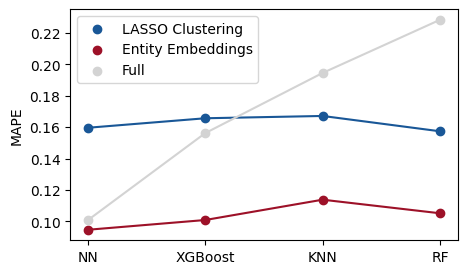

+-------------+------------+------------------------+-----------+
|    Model    | LASSO MAPE | Entity Embeddings MAPE | Full MAPE |
+-------------+------------+------------------------+-----------+
|     NN      |   0.1597   |         0.0947         |  0.1008   |
|   XGBoost   |   0.1657   |         0.1009         |  0.1562   |
|     KNN     |   0.1672   |         0.1139         |  0.1946   |
|     RF      |   0.1574   |         0.1052         |  0.2284   |
| % Reduction |   95.94%   |         96.45%         |   0.00%   |
+-------------+------------+------------------------+-----------+


In [35]:
"""with open('mape final/mape_results_final_w_reduction.json', 'r') as f:
    data = json.load(f)"""

# Extract the MAPE dictionaries
'''ee_mape = data["ee_mape"]
lasso_mape = data["lasso_mape"]
full_mape = data["full_mape"]'''

percent_reduct_ee = data['reduction'][0]
percent_reduct_lasso = data['reduction'][1]
percent_reduct_full = data['reduction'][2]


models = ['NN', 'XGBoost', 'KNN', 'RF']
k = [0, 2, 3, 1]
lasso_values = list(lasso_mape.values())
lasso_values = [lasso_values[i] for i in k]

ee_values = list(ee_mape.values())
ee_values = [ee_values[i] for i in k]

full_values = list(full_mape.values())
full_values = [full_values[i] for i in k]

cmap = cm.get_cmap('RdBu', 15)

red_color = cmap(1)
blue_color = cmap(13)

plt.figure(figsize=(5, 3))
x_positions = range(len(models))

plt.scatter(x_positions, lasso_values, color=blue_color, label='LASSO Clustering')
plt.scatter(x_positions, ee_values, color=red_color, label='Entity Embeddings')
plt.scatter(x_positions, full_values, color='lightgray', label='Full')

plt.plot(x_positions, lasso_values, color=blue_color, linestyle='-')
plt.plot(x_positions, ee_values, color=red_color, linestyle='-')
plt.plot(x_positions, full_values, color='lightgray', linestyle='-')

plt.xticks(x_positions, models)
plt.ylabel('MAPE')
plt.legend()
#plt.savefig('results.pdf', bbox_inches='tight')
plt.show()

from tabulate import tabulate

table_data = []
for model, las, ee, full in zip(models, lasso_values, ee_values, full_values):
    table_data.append([model, f"{las:.4f}", f"{ee:.4f}", f"{full:.4f}"])

table_data.append(['% Reduction', f"{percent_reduct_lasso:.2%}", f"{percent_reduct_ee:.2%}", f"{percent_reduct_full:.2%}"])

headers = ["Model", "LASSO MAPE", "Entity Embeddings MAPE", "Full MAPE"]
print(tabulate(table_data, headers=headers, tablefmt="pretty"))